# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">2. Model Training for Gemstone Dataset - Sanket Devakar</p>

### Loading the necessary Libraries

In [1]:
# Basic Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
# Modelling
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor,AdaBoostRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression, Ridge,Lasso
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from catboost import CatBoostRegressor
from xgboost import XGBRegressor

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Read the Dataset</p>

In [2]:
df = pd.read_csv('data/gemstone.csv')
df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,x,y,z,price
0,1,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,2,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,3,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,4,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,5,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


### Dropping id Column

In [3]:
df = df.drop(columns=['Unnamed: 0'],axis=1)
df.head()

,carat,cut,color,clarity,depth,table,x,y,z,price
0,0.30,Ideal,E,SI1,62.1,58.0,4.27,4.29,2.66,499
1,0.33,Premium,G,IF,60.8,58.0,4.42,4.46,2.70,984
2,0.90,Very Good,E,VVS2,62.2,60.0,6.04,6.12,3.78,6289
3,0.42,Ideal,F,VS1,61.6,56.0,4.82,4.80,2.96,1082
4,0.31,Ideal,F,VVS1,60.4,59.0,4.35,4.43,2.65,779


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Getting X and Y variables</p>

In [4]:
X = df.drop(columns=['price'],axis=1)
Y = df[['price']]

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Creating Data Transformation Pipeline</p>

### Creating Pipeline with Column Transformer

In [5]:
# Define which columns should be ordinal-encoded and which should be scaled
categorical_cols = X.select_dtypes(include='object').columns
numerical_cols = X.select_dtypes(exclude='object').columns
            
# Define the custom ranking for each ordinal variable
cut_categories = ['Fair', 'Good', 'Very Good','Premium','Ideal']
color_categories = ['D', 'E', 'F', 'G', 'H', 'I', 'J']
clarity_categories = ['I1','SI2','SI1','VS2','VS1','VVS2','VVS1','IF']

from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder,StandardScaler

# Numerical Pipeline
num_pipeline = Pipeline(
                steps = [
                ('imputer',SimpleImputer(strategy='median')),
                ('scaler',StandardScaler())                
                ]
            )

# Categorical Pipeline
cat_pipeline = Pipeline(
                steps=[
                ('imputer',SimpleImputer(strategy='most_frequent')),
                ('ordinal_encoder',OrdinalEncoder(categories=[cut_categories,color_categories,clarity_categories])),
                ('scaler',StandardScaler())
                ]
            )

preprocessor = ColumnTransformer(
                [
                ('num_pipeline',num_pipeline,numerical_cols),
                ('cat_pipeline',cat_pipeline,categorical_cols)
                ]
            )

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Train Test Split</p>

In [6]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(X,Y,test_size=0.2,random_state=42)

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Transforming the data with pipeline created</p>

In [7]:
xtrain = pd.DataFrame(preprocessor.fit_transform(xtrain),columns=preprocessor.get_feature_names_out())
xtest = pd.DataFrame(preprocessor.transform(xtest),columns=preprocessor.get_feature_names_out())

In [8]:
preprocessor.get_feature_names_out()

array(['num_pipeline__carat', 'num_pipeline__depth',
       'num_pipeline__table', 'num_pipeline__x', 'num_pipeline__y',
       'num_pipeline__z', 'cat_pipeline__cut', 'cat_pipeline__color',
       'cat_pipeline__clarity'], dtype=object)

In [9]:
xtrain.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,-0.627970,0.036089,-2.436769,-0.561384,-0.522367,-0.485944,-0.814476,0.231511,-0.639166
1,1.540292,-0.538595,1.135271,1.510650,1.493540,1.410577,0.083087,0.231511,0.576396
2,0.424584,-0.323089,-1.543759,0.568008,0.588622,0.534155,-0.814476,-1.527694,-0.639166
3,1.645548,-0.538595,0.242261,1.626257,1.574177,1.511150,0.083087,1.990716,1.184177
4,-0.164846,0.036089,-0.650749,-0.010027,0.006249,0.002554,0.980650,-0.354891,-0.031385


In [10]:
xtest.head()

,num_pipeline__carat,num_pipeline__depth,num_pipeline__table,num_pipeline__x,num_pipeline__y,num_pipeline__z,cat_pipeline__cut,cat_pipeline__color,cat_pipeline__clarity
0,0.635095,-0.897773,1.135271,0.817008,0.839490,0.706565,-0.814476,-0.354891,-0.639166
1,-0.817430,1.257294,-1.097254,-0.925991,-0.898669,-0.787663,-1.712040,-0.941292,-1.246947
2,-1.154247,-1.400622,0.688766,-1.477347,-1.472083,-1.577880,0.083087,0.817912,1.791958
3,1.519241,0.754445,-0.650749,1.412829,1.403944,1.511150,0.980650,0.817912,1.184177
4,-0.796379,0.251596,-1.097254,-0.845955,-0.826993,-0.802030,0.980650,-1.527694,1.184177


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Model Training Baseline models</p>

### Create an Evaluate Function to give all metrics after model Training

In [11]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    r2_square = r2_score(true, predicted)
    return mae, rmse, r2_square

### Training Various models

In [12]:
models = {
    "Linear Regression": LinearRegression(),
    "Lasso": Lasso(),
    "Ridge": Ridge(),
    "K-Neighbors Regressor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest Regressor": RandomForestRegressor(),
    "XGBRegressor": XGBRegressor(), 
    "CatBoosting Regressor": CatBoostRegressor(verbose=False),
    "AdaBoost Regressor": AdaBoostRegressor()
}
model_list = []
r2_list =[]

for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(xtrain, ytrain.values.flatten()) # Train model

    # Make predictions
    y_train_pred = model.predict(xtrain)
    y_test_pred = model.predict(xtest)
    
    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, y_train_pred)

    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, y_test_pred)

    
    print(list(models.keys())[i])
    model_list.append(list(models.keys())[i])
    
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))
    r2_list.append(model_test_r2)
    
    print('='*35)
    print('\n')

Linear Regression
Model performance for Training set
- Root Mean Squared Error: 1208.1551
- Mean Absolute Error: 809.4854
- R2 Score: 0.9090
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1735.7824
- Mean Absolute Error: 852.9111
- R2 Score: 0.8210




c:\Users\Sanket\Desktop\GemstonePricePredictor\venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.340e+08, tolerance: 3.460e+07
  model = cd_fast.enet_coordinate_descent(


Lasso
Model performance for Training set
- Root Mean Squared Error: 1208.9044
- Mean Absolute Error: 809.2109
- R2 Score: 0.9089
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1433.9991
- Mean Absolute Error: 845.0779
- R2 Score: 0.8779


Ridge
Model performance for Training set
- Root Mean Squared Error: 1208.1618
- Mean Absolute Error: 809.5158
- R2 Score: 0.9090
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 1706.1242
- Mean Absolute Error: 852.3562
- R2 Score: 0.8271


K-Neighbors Regressor
Model performance for Training set
- Root Mean Squared Error: 626.6117
- Mean Absolute Error: 329.2975
- R2 Score: 0.9755
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 831.6168
- Mean Absolute Error: 409.8755
- R2 Score: 0.9589


Decision Tree
Model performance for Training set
- Root Mean Squared Error: 5.6729
- Mean Absolute Error: 0.2662
- R2 Score: 1.0000

### Results

In [13]:
df_results = pd.DataFrame(list(zip(model_list, r2_list)), columns=['Model Name', 'R2_Score']).sort_values(by=["R2_Score"],ascending=False)
df_results

,Model Name,R2_Score
7,CatBoosting Regressor,0.981793
6,XGBRegressor,0.981291
5,Random Forest Regressor,0.981041
4,Decision Tree,0.963949
3,K-Neighbors Regressor,0.958923
8,AdaBoost Regressor,0.921976
1,Lasso,0.877864
2,Ridge,0.827110
0,Linear Regression,0.821047


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Hyperparameter tuning</p>

### Tuning Catboost

In [14]:
# Initializing catboost
cbr = CatBoostRegressor(verbose=False)

# Creating the hyperparameter grid
param_dist = {'depth'          : [4,5,6,7,8,9, 10],
              'learning_rate' : [0.01,0.02,0.03,0.04],
               'iterations'    : [300,400,500,600]}

#Instantiate RandomSearchCV object
rscv = RandomizedSearchCV(cbr , param_dist, scoring='r2', cv =5, n_jobs=-1)

# Fit the model
rscv.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rscv.best_params_)
print(rscv.best_score_)

{'learning_rate': 0.04, 'iterations': 600, 'depth': 8}
0.9817185148741169


### Definition to print evaluated model results

In [15]:
def print_evaluated_results(model,xtrain,ytrain,xtest,ytest):
    ytrain_pred = model.predict(xtrain)
    ytest_pred = model.predict(xtest)

    # Evaluate Train and Test dataset
    model_train_mae , model_train_rmse, model_train_r2 = evaluate_model(ytrain, ytrain_pred)
    model_test_mae , model_test_rmse, model_test_r2 = evaluate_model(ytest, ytest_pred)

    # Printing results
    print('Model performance for Training set')
    print("- Root Mean Squared Error: {:.4f}".format(model_train_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_train_mae))
    print("- R2 Score: {:.4f}".format(model_train_r2))

    print('----------------------------------')
    
    print('Model performance for Test set')
    print("- Root Mean Squared Error: {:.4f}".format(model_test_rmse))
    print("- Mean Absolute Error: {:.4f}".format(model_test_mae))
    print("- R2 Score: {:.4f}".format(model_test_r2))

In [16]:
# Selecting best model
best_cbr = rscv.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_cbr,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 442.7808
- Mean Absolute Error: 248.8812
- R2 Score: 0.9878
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 565.2740
- Mean Absolute Error: 283.9265
- R2 Score: 0.9810


### Tuning KNN

In [17]:
from sklearn.model_selection import GridSearchCV
# Initialize knn
knn = KNeighborsRegressor()

# parameters
k_range = list(range(2, 31))
param_grid = dict(n_neighbors=k_range)

# Fitting the cvmodel
grid = GridSearchCV(knn, param_grid, cv=5, scoring='r2',n_jobs=-1)
grid.fit(xtrain, ytrain)

# Print the tuned parameters and score
print(grid.best_params_)
print(grid.best_score_)

{'n_neighbors': 11}
0.9634707698097353


In [18]:
# Selecting best model
best_knn = grid.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_knn,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 687.4470
- Mean Absolute Error: 360.0847
- R2 Score: 0.9705
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 829.6279
- Mean Absolute Error: 405.2713
- R2 Score: 0.9591


### Tuning XGBoost

In [19]:
# Initializing xgboost
xgb = XGBRegressor()

# Parameters
params = {
 'learning_rate' : [0.05,0.10,0.15,0.20,0.25,0.30],
 'max_depth' : [ 3, 4, 5, 6, 8, 10, 12, 15],
 'min_child_weight' : [ 1, 3, 5, 7 ],
 'gamma': [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
 'colsample_bytree' : [ 0.3, 0.4, 0.5 , 0.7 ],
 'n_estimators':[300,400,500,600]
}

rs_xgb=RandomizedSearchCV(xgb,param_distributions=params,scoring='r2',n_jobs=-1,cv=5)
rs_xgb.fit(xtrain, ytrain.values.flatten())

# Print the tuned parameters and score
print(rs_xgb.best_params_)
print(rs_xgb.best_score_)

{'n_estimators': 600, 'min_child_weight': 7, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0.2, 'colsample_bytree': 0.5}
0.9807117462158204


In [20]:
# Selecting best xgb model
best_xgb = rs_xgb.best_estimator_

# Evaluate Train and Test dataset
print_evaluated_results(best_xgb,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 385.8800
- Mean Absolute Error: 217.2276
- R2 Score: 0.9907
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 547.8177
- Mean Absolute Error: 279.2071
- R2 Score: 0.9822


# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Voting Regressor</p>

In [21]:
from sklearn.ensemble import VotingRegressor

er = VotingRegressor([('cbr',best_cbr),('knn',best_knn),('xgb',XGBRegressor())], weights=[3,1,2])
er.fit(xtrain, ytrain.values.flatten())

print_evaluated_results(er,xtrain,ytrain,xtest,ytest)

Model performance for Training set
- Root Mean Squared Error: 407.3589
- Mean Absolute Error: 230.2129
- R2 Score: 0.9897
----------------------------------
Model performance for Test set
- Root Mean Squared Error: 560.8168
- Mean Absolute Error: 282.1160
- R2 Score: 0.9813


### Model improved with Ensemble technique !

# <p style="padding:10px;background-color:#87CEEB ;margin:10;color:#000000;font-family:newtimeroman;font-size:100%;text-align:center;border-radius: 10px 10px ;overflow:hidden;font-weight:50">Catboost Model Feature Importances</p>

num_pipeline__carat      23.155159
cat_pipeline__clarity    18.770131
num_pipeline__y          17.328427
num_pipeline__z          15.453254
num_pipeline__x          12.285209
cat_pipeline__color      11.316052
cat_pipeline__cut         0.822470
num_pipeline__depth       0.465257
num_pipeline__table       0.404040
dtype: float64




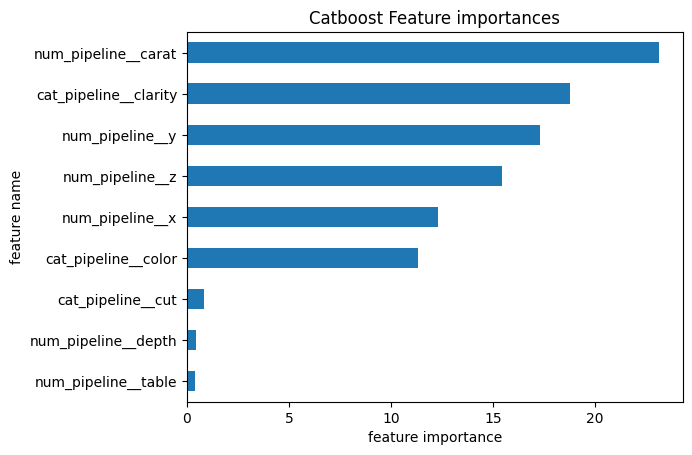

In [22]:
feature_imp = best_cbr.feature_importances_
feature_nm = best_cbr.feature_names_
imp_series = pd.Series(feature_imp)
imp_series.index = feature_nm
print(imp_series.sort_values(ascending=False))
print('\n')
imp_series.sort_values().plot(kind='barh',
                              xlabel='feature importance',
                              ylabel='feature name',
                              title='Catboost Feature importances')

plt.show()